In [96]:
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import math

sampleRate, amplitude = wavfile.read("hello.wav")
length = len(amplitude)
frameWidth = int(0.025*sampleRate)
frameShift = int(0.01*sampleRate)
amplitude = [i/32768 for i in amplitude]

print("sampleRate:"+str(sampleRate))
print("length:"+str(length))
print("frameWidth:"+str(frameWidth))
print("frameShift:"+str(frameShift))

sampleRate:44100
length:26752
frameWidth:1102
frameShift:441


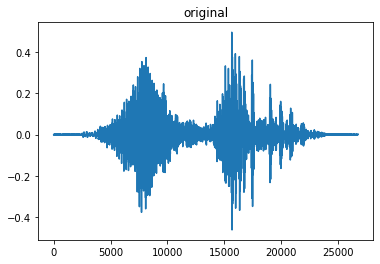

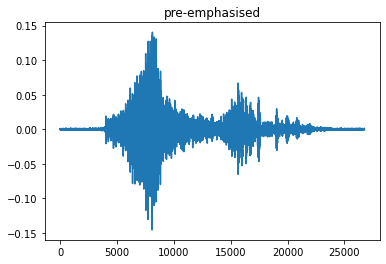

In [97]:
# Pre-emphasis

emphasisedAmplitude = []

for index in range(1,length):
    # formula of  pre-emphasis
    temp = amplitude[index]-0.97*amplitude[index-1]
    emphasisedAmplitude.append(temp)

plt.title("original")
plt.plot(amplitude)
plt.show()

plt.title("pre-emphasised")
plt.plot(emphasisedAmplitude)
plt.show()

27121


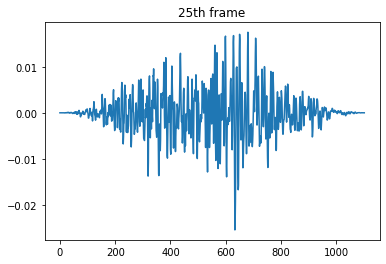

In [98]:

# windowing

# Hanning window function
def getHanning(n, frameWidth):
    return 0.5-0.5*np.cos((2*np.pi*n)/(frameWidth-1))

# fill with 0
zeroCount = (len(emphasisedAmplitude)-frameWidth)%frameShift
for i in range(frameShift-zeroCount):
    emphasisedAmplitude.append(0)

print(len(emphasisedAmplitude))
windowingFrames = []

# find the start of each frame
for start in range(0, len(emphasisedAmplitude)-frameWidth+1, frameShift):
    temp = []
    # window the frames
    for index in range(frameWidth):
        temp.append(emphasisedAmplitude[index+start]*getHanning(index, frameWidth))   
    windowingFrames.append(temp)

    # print the 25th frame
    if start==25*frameShift:
        plt.title("25th frame")
        plt.plot(temp)
        plt.show()

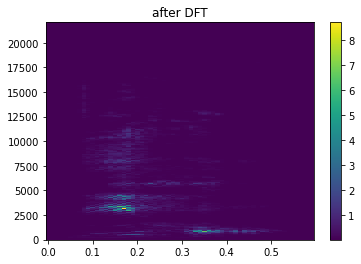

In [99]:
# DFT

# get DFT of frames in abs
def DFT(frames):
    dft = []
    # get DFT of each frames in plural
    for frame in frames:
        dft.append(np.fft.rfft(frame))

    ans = []
    for nd in dft:
        temp = []
        for x in nd:
            temp.append(abs(x))
        ans.append(temp)
    return ans

spectrum = np.array(DFT(windowingFrames))

x = [i*frameShift/sampleRate for i in range(spectrum.shape[0])]
y = [i*sampleRate/frameWidth for i in range(spectrum.shape[1])]

plt.title("after DFT")
plt.pcolormesh(x, y, np.transpose(spectrum), shading='auto')
plt.colorbar()
plt.show()

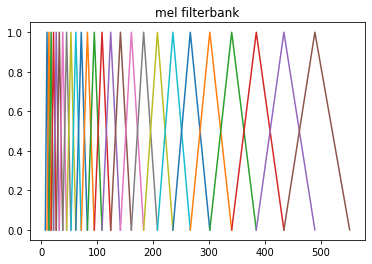

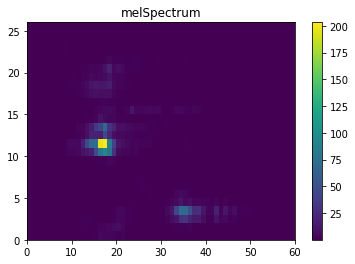

In [100]:
# Mel Filterbank

# hz to mel
def melfrequence(x):
    return 1125*math.log(1+x/700)

# mel to hz
def melfrequenceInverse(x):
    return 700*(math.pow(math.e, x/1125)-1)

# function used in mel filterbanks to get bins
# m：number of the filterbank（started with 0） 
# M：amount of filterbanks
def f(m, M):
    # range of frequnce
    fmax = sampleRate/2
    fmin = 300
    return (frameWidth/sampleRate)*melfrequenceInverse(melfrequence(fmin)+m*(melfrequence(fmax)-melfrequence(fmin))/(M+1))

# mel filterbanks
# k：x axis
# m：number of the filterbank（started with 0）  
# M：amount of filterbanks
def getMelFilterbank(k, m, M):
    min = f(m, M)
    mid = f(m+1, M)
    max = f(m+2, M)
    if k<min or k>max:
        return 0
    elif min<=k and k<=mid:
        return (k-min)/(mid-min)
    elif mid<k and k<=max:
        return (max-k)/(max-mid)

# amount of filterbanks
M = 26
for i in range(M):
    temp = []
    temp.append(f(i,M))
    temp.append(f(i+1,M))
    temp.append(f(i+2,M))
    plt.plot(temp, [0,1,0])

plt.title("mel filterbank")
plt.show()

# calculate melspectrum
def getMelSpectrum():
    ans = []
    for frame in spectrum:
        temp = []
        for m in range(M):
            y = 0
            for k in range(spectrum.shape[1]):
                y += getMelFilterbank(k, m, M)*frame[k]*frame[k]
            temp.append(y)
        ans.append(temp)
    return ans

melSpectrum = np.array(getMelSpectrum())

plt.title("melSpectrum")
plt.pcolormesh(np.transpose(melSpectrum))
plt.colorbar()
plt.show()

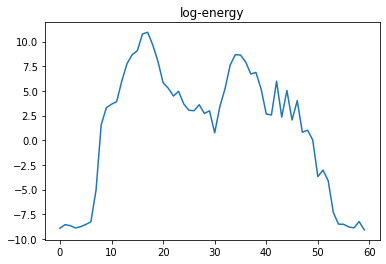

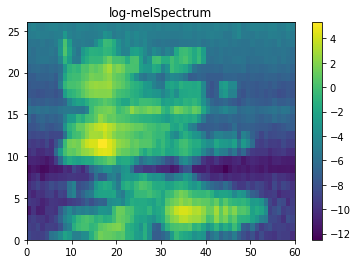

In [101]:
# log()
energy = []
for frame in melSpectrum:
    sum = np.finfo("float").eps
    for i in frame:
        sum += i**2 
    energy.append(math.log(sum))
energy = np.array(energy)

plt.title("log-energy")
plt.plot(energy)
plt.show()

melSpectrum = np.log(melSpectrum+np.finfo("float").eps)

plt.title("log-melSpectrum")
plt.pcolormesh(np.transpose(melSpectrum))
plt.colorbar()
plt.show()

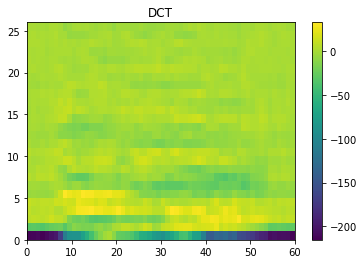

In [102]:
# DCT
def DCT():
    ans = []
    for frame in melSpectrum:
        temp = []
        for j in range(melSpectrum.shape[1]):
            sum = 0
            for m in range(M):
                sum += frame[m]*math.cos((m+0.5)*j*np.pi/M)
            temp.append(sum)
        ans.append(temp)
        
    return ans

dct = np.squeeze(np.array(DCT()))

plt.title("DCT")
plt.pcolormesh(np.transpose(dct))
plt.colorbar()
plt.show()


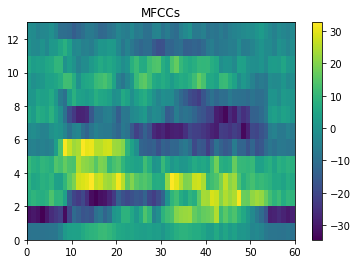

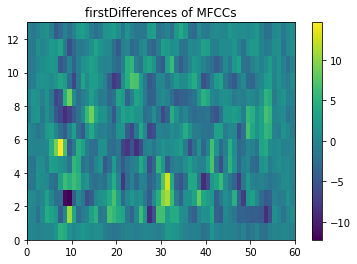

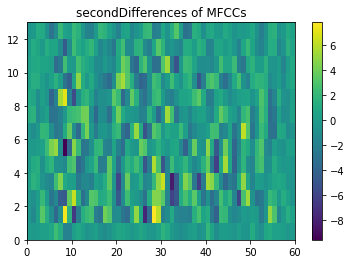

In [103]:
# Dynamic feature extraction

# calculate the first differences of array(1D)
def getFirstDifferences(array):
    ans = []
    ans.append((array[1]-array[0])/2)
    for index in range(1,array.shape[0]-1):
        ans.append((array[index+1]-array[index-1])/2)
    ans.append((array[array.shape[0]-1]-array[array.shape[0]-2])/2)
    return ans

# calculate the first and second differences of dct
dct = np.transpose(dct)

firstDifferences = []
for vector in dct:
    firstDifferences.append(getFirstDifferences(vector))
firstDifferences = np.array(firstDifferences)

secondDifferences = []
for vector in firstDifferences:
    secondDifferences.append(getFirstDifferences(vector))
secondDifferences = np.array(secondDifferences)

dct = np.transpose(dct)
firstDifferences = np.transpose(firstDifferences)
secondDifferences = np.transpose(secondDifferences)

# cut bits 1 to 12 from each frame
MFCCs = dct[:,1:13]
deltaMFCCs = firstDifferences[:,1:13]
delta2MFCCs = secondDifferences[:,1:13]

# calculate the first and second differences of energy
deltaEnergy = np.array(getFirstDifferences(energy))
delta2Energy = np.array(getFirstDifferences(deltaEnergy))

# add energy and its differences in MFCCs as the thirteenth feature(but showed in first)
MFCCs = np.insert(MFCCs, 0, energy, axis=1)
deltaMFCCs = np.insert(deltaMFCCs, 0 , deltaEnergy, axis=1)
delta2MFCCs = np.insert(delta2MFCCs, 0, delta2Energy, axis=1)

plt.title("MFCCs")
plt.pcolormesh(np.transpose(MFCCs))
plt.colorbar()
plt.show()

plt.title("firstDifferences of MFCCs")
plt.pcolormesh(np.transpose(deltaMFCCs))
plt.colorbar()
plt.show()

plt.title("secondDifferences of MFCCs")
plt.pcolormesh(np.transpose(delta2MFCCs))
plt.colorbar()
plt.show()

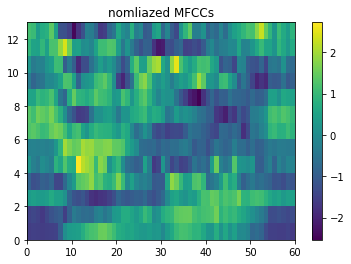

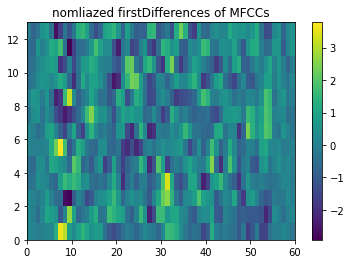

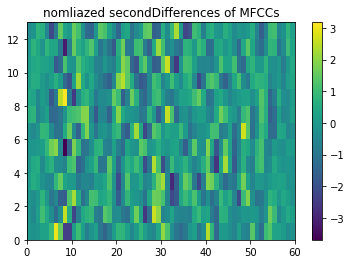

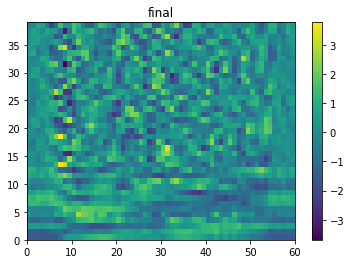

(60, 39)


In [104]:
# Feature transformation

# 0-1 normalization(to 1D array)
def nomarlize(array):
    # get length
    count = array.shape[0]
    # calculate the average
    sum = 0
    for index in range(count):
        sum += array[index]
    average = sum/count
    # calculate the variance
    temp = 0
    for index in range(count):
        temp += (array[index]-average)**2
    variance = math.sqrt(temp/(count-1))
    # normalize
    ans = [(i-average)/variance for i in array]
    return ans

# normalize each row in array(2D)
def nomalize2DArray(array):
    ans = []
    temp = np.transpose(array)
    for vector in temp:
        ans.append(nomarlize(vector))
    return np.transpose(ans)

# normalize feature vectors
MFCCs = np.array(nomalize2DArray(MFCCs))
deltaMFCCs = np.array(nomalize2DArray(deltaMFCCs))
delta2MFCCs = np.array(nomalize2DArray(delta2MFCCs))

plt.title("nomliazed MFCCs")
plt.pcolormesh(np.transpose(MFCCs))
plt.colorbar()
plt.show()

plt.title("nomliazed firstDifferences of MFCCs")
plt.pcolormesh(np.transpose(deltaMFCCs))
plt.colorbar()
plt.show()

plt.title("nomliazed secondDifferences of MFCCs")
plt.pcolormesh(np.transpose(delta2MFCCs))
plt.colorbar()
plt.show()

final = np.concatenate((MFCCs, deltaMFCCs, delta2MFCCs), axis=1)

plt.title("final")
plt.pcolormesh(np.transpose(final))
plt.colorbar()
plt.show()